# This is a work-in-progress notebook

We wish to know this:

1. How well does the model identify the correct number of senses for the target word?
2. **How well does the model identify the correct senses for the target word?**
3. **How well does the model assign the right words to a given sense of the target word?**
4. How well does the model assign the senses to the time intervals for the target word?

The script will evaluate **Q2** and **Q3**. Q4 will follow.

In [5]:
# Basic variables and imports:

import codecs, csv, os, time, re, io
from os import listdir
from os.path import isfile, join

# directories
dir_in = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "evaluation", "evaluation_input"))
dir_out = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "evaluation", "evaluation_output"))


s_senses = io.open(dir_in+"/senses_69419.txt","r")
k_senses = io.open(dir_in+"/mus.dat","r")

# DEBUG:
#s_senses = io.open(dir_in+"/senses_69419_debug.txt","r")
#k_senses = io.open(dir_in+"/mus_debug.dat","r")
# k0 = mus4
# k1 = mus3
# k2 = mus2
# k3 = mus1
# k4 = nothing

file_senses = s_senses.readlines()[1:]
output_senses = k_senses.read()

<_io.TextIOWrapper name='/Users/hengchen/git/seed-semantic-change/evaluation/evaluation_input/senses_69419.txt' mode='r' encoding='UTF-8'>


## TODO

- ~~create the notebook~~
- ~~organise the notebook~~
- ~~write "general idea" pseudocode for the evaluation~~
- ~~get input files~~
- ~~figure out data structures to store the variables~~
- ~~write actual code~~

## Q2: How well does the model identify the correct senses for the target word?

### Pseudocode 

In [6]:
# For each target word, we have a list of senses  s (given by the expert)
# For each target word, we have a list of senses k (given by the model)
# This Q consists in matching s and k, and doing so in a confident way --> confidence score

for each k:
    for each s:
        create conf(k,s)

# What is conf(k,s)?
        conf(k,s) = (p1*match(w1,s)+p2*match(w1,s)+px(wx,s))/10 WHERE
    
            px = probability of word wx 
                
                and
            
            match(wx,s) =   1/number_of_senses_assigned_to_wx if s_is_one_of_them 
            
                    or 
                            0 if w_is_not_associated_to_s
                
# Once we have gone through all s for one k, we have to choose the best k for s. How? (TBD, cfr Valerio and Barbara)

# Once all ks have been assigned to all ss (or NA), we can calculate a general confidence score for the model.
# One easy way to do that: 

conf_score_model = number_of_non_NA/k

SyntaxError: invalid syntax (<ipython-input-6-82fa54601c9a>, line 5)

### Real code

Steps:

- extract all senses from the file
- use those senses as keys for a dictionary, `dict_of_words`
- fill the dictionary: for each key, we store a list of words pertaining to that sense
- transform the lists as sets so as to remove duplicates within the same sense
- create a dictionary with a word as a key and its weight as a value, depending on how many senses it appears
- parse the model output and get the probability weights for each word
- do not take into account the first line
- take care of empty lines

Todo:



In [7]:
expert_senses = list() # list where we store all sense ids provided by expert
for s in file_senses: # 60 for testing purposes
    s = s.split("\t")
    sense = s[11] # The sense ID is after the 10th tab
    expert_senses.append(sense)
    
#print(len(expert_senses),expert_senses,len(set(expert_senses)))

expert_senses = list(set(expert_senses)) # we only keep the unique senses
number_of_s = len(expert_senses)  # we create a variable that stores the number of unique senses
print("Number of senses:",number_of_s)

# This dictionary has a sense as a key, and a list of words as a value. 
dict_of_words = dict()
# This list stores all words
list_of_all_words = list()
# This dictionary stores all words as keys and their weight as value
word_weight = dict()

for i in range(0,number_of_s): # for each sense, we create a dictionary entry which has a list as value
    dict_of_words[expert_senses[i]] = list()

    for s in file_senses: # we go back in the file
        s = s.split("\t") # splitting on tabs
        
        sentence_of_ids = s[8] # 8 is for IDs, 9 is for words
        list_of_ids = sentence_of_ids.split(" ")  # splitting on spaces
        for word_id in list_of_ids:
            if s[11] == expert_senses[i]:      # we store all words for one sense 
                dict_of_words[expert_senses[i]].append(word_id)
            list_of_all_words.append(word_id) # we store all words, we'll iterate over that for scores
        

    # Here, we remove duplicates
    #dict_of_words[expert_senses[i]].append("79223") #testing
    dict_of_words[expert_senses[i]] = set(dict_of_words[expert_senses[i]]) 
      
    print(expert_senses[i],set(dict_of_words[expert_senses[i]]))
    print("\n\n")


Number of senses: 4
mus-1 {'66173', '7561', '93796', '101853', '69419', '28355', '116058', '113823', '7944', '31709', '83756', '102847', '34372', '16171', '72357', '3464', '95819', '80557', '51815', '36571', '68791', '84094', '73128', '95853', '26233', '84725', '15162', '43089', '27209', '56874', '14181', '7498', 'nlsj47984', '62204', '34366', '106974', '82959', '104690', '49506', '18166', '113711', '106502', 'nlsj10876', '23242', '30911', '19123', '62205', '76431', '50824', '85417', '29974', '89807', '49331', '70105', '4587', '19711', '95654', '19972', '26136', '24801', '26207', '72268', '23658', '45285', '34603', '80239', '112347', '73972', '11206', '42887', '91516', '72275', '110114', '65089', '52460', '37851', '61885', 'nlsj4012', '26499', '109403', '46176', '38966', '46966', '5009', '110484', '4335', '47917', '51647', '98234', '3237', '45917', '7182', '14050', '46216', '103957', '33770', '53161', '53956', '68174', '63212', '70477', '2767', '112351', '4906', '52095', '70482', '6230

In [8]:
# For every word in the list of words that we have
# we count the number of senses it appears in
# we use that number to divide its importance: 1 sense = 1 importance; 2 senses = 0.5 importance
# this can be finetuned

for word in list_of_all_words:
    x = 0
    for i in range(0,number_of_s):
        if word in dict_of_words[expert_senses[i]]:
            x += 1 
        if x != 0:
            word_weight[word] = 1/x
        
    
    #print(word,word_weight[word])  

#### parsing output.dat
- split on "===============  per time  ===============" and keep first part
- transform that into a list, then
- get lines that start with "p(w|s)"
- count those, k = that number
- split the line on ":", keep the second part
- split the rest on ";", it's [ID] = prob_from_this_ID

In [9]:
lines_output = output_senses.split("===============  per time  ===============")[0].split("\n")

number_of_the_k = 0

k_words_with_prob = dict()

for line in lines_output:
    if line[:6] == "p(w|s)":
        line = line.split(":")[1]
        line = line.split(";")
        #print(number_of_the_k,line)
        dico_word_prob = dict()
        temp_dict = dict()
        k_words_with_prob[number_of_the_k] = list()
        
        line = line[:-1] # last item of the list is empty
        
        total_probability = 0 # to have relative probs
        for word_prob in line:
            

        
            #word_prob = word_prob.split(",")
            #for word in word_prob:
            probability = re.findall("([\d.\w]*)",word_prob)
            if probability:
                probability = list(filter(None,probability))
                    
            total_probability += float(probability[1])
            print("word id",probability[0],"; probability",probability[1])
        
            dico_word_prob[probability[0]] = float(probability[1])
        #print(type(k_words_with_prob[number_of_the_k]))
        
        for i in dico_word_prob.keys():
            
            temp_dict[i] = float(dico_word_prob[i]/total_probability)
            k_words_with_prob[number_of_the_k] = temp_dict
            
            print(k_words_with_prob[number_of_the_k])
            
        #k_words_with_prob[number_of_the_k] = [float(dico_word_prob[i]/total_probability) for i in dico_word_prob]
        #print(k_words_with_prob[number_of_the_k])
        print(temp_dict)
        number_of_the_k += 1
        



word id 28355 ; probability 0.088
word id 69419 ; probability 0.069
word id 57460 ; probability 0.056
word id 114587 ; probability 0.042
word id 42071 ; probability 0.041
word id 35267 ; probability 0.035
word id 51647 ; probability 0.035
word id 64448 ; probability 0.023
word id 45980 ; probability 0.018
word id 53826 ; probability 0.017
{'28355': 0.2075471698113207}
{'28355': 0.2075471698113207, '69419': 0.16273584905660377}
{'28355': 0.2075471698113207, '69419': 0.16273584905660377, '57460': 0.1320754716981132}
{'28355': 0.2075471698113207, '69419': 0.16273584905660377, '57460': 0.1320754716981132, '114587': 0.0990566037735849}
{'28355': 0.2075471698113207, '69419': 0.16273584905660377, '57460': 0.1320754716981132, '114587': 0.0990566037735849, '42071': 0.09669811320754716}
{'28355': 0.2075471698113207, '69419': 0.16273584905660377, '57460': 0.1320754716981132, '114587': 0.0990566037735849, '42071': 0.09669811320754716, '35267': 0.08254716981132075}
{'28355': 0.2075471698113207, '69

#### k_words_with_prob
This dictionary has the sense number 'k' as keys and the a dictionary of [word] = probability as values.
Example below.

In [10]:
#print("Probability for word ID 5390 in sense k = 4:",k_words_with_prob[4]["5390"])
print(type(k_words_with_prob[4]))

<class 'dict'>


In [11]:
for key in k_words_with_prob.keys():
    print("output sense",key)
    for i in range(0,number_of_s):
        print("\texpert sense number ", i, expert_senses[i])
        for second_key in k_words_with_prob[key].keys(): # Barbara's note: shouldn't it be k_words_with_prob[i] here?
            print("\t\tword from annotation for sense", key, ":", second_key)
            if second_key in dict_of_words[expert_senses[i]]:
                print("\t\t\tword ", second_key, "is in output for sense", key, "with probability:", k_words_with_prob[key][second_key], "and weight:", word_weight[second_key])

                
# Here we get all the senses and for each sense we do a matching between the k words and s words and get the probability
# For some reason the first word for each sense arrives several times


output sense 0
	expert sense number  0 mus-1
		word from annotation for sense 0 : 28355
			word  28355 is in output for sense 0 with probability: 0.2075471698113207 and weight: 1.0
		word from annotation for sense 0 : 69419
			word  69419 is in output for sense 0 with probability: 0.16273584905660377 and weight: 0.25
		word from annotation for sense 0 : 57460
		word from annotation for sense 0 : 114587
			word  114587 is in output for sense 0 with probability: 0.0990566037735849 and weight: 1.0
		word from annotation for sense 0 : 42071
		word from annotation for sense 0 : 35267
			word  35267 is in output for sense 0 with probability: 0.08254716981132075 and weight: 1.0
		word from annotation for sense 0 : 51647
			word  51647 is in output for sense 0 with probability: 0.08254716981132075 and weight: 1.0
		word from annotation for sense 0 : 64448
			word  64448 is in output for sense 0 with probability: 0.05424528301886792 and weight: 1.0
		word from annotation for sense 0 : 45980
			

			word  16132 is in output for sense 3 with probability: 0.06808510638297872 and weight: 1.0
output sense 4
	expert sense number  0 mus-1
		word from annotation for sense 4 : nlsj5634
		word from annotation for sense 4 : 61925
			word  61925 is in output for sense 4 with probability: 0.13909774436090228 and weight: 1.0
		word from annotation for sense 4 : 12620
		word from annotation for sense 4 : 69419
			word  69419 is in output for sense 4 with probability: 0.10150375939849625 and weight: 0.25
		word from annotation for sense 4 : 104421
			word  104421 is in output for sense 4 with probability: 0.10150375939849625 and weight: 0.5
		word from annotation for sense 4 : 91085
			word  91085 is in output for sense 4 with probability: 0.09022556390977446 and weight: 1.0
		word from annotation for sense 4 : 71308
			word  71308 is in output for sense 4 with probability: 0.08270676691729324 and weight: 0.5
		word from annotation for sense 4 : 115748
		word from annotation for sense 4 : 196

In [12]:
## Calculating confidence score for each (words_of_k,words_of_s) pair

# conf(k,s) = (p1*match(w1,s)+p2*match(w1,s)+px(wx,s))/10
        # match(wx,s) =   1/number_of_senses_assigned_to_wx if s_is_one_of_them 

##### TODO: for now conf[k,s] is multiplied by the number of expert senses --- FIX
    
print("number of expert senses s:",number_of_s)
print("number of model output senses k:",len(k_words_with_prob.keys()))
compteur = 0

match = dict()
conf = dict()
for k in k_words_with_prob.keys():  # for each output sense, we go through...
    print("\n")
    print("Choose best match for k =",k)
    for s in range(0,number_of_s):       # each expert sense
        
        conf[k,s] = 0 
        
        #print("expert sense",s)
        for mot in k_words_with_prob[k]:      # for each word within output by the model for the output sense
            #print(k,mot)
            #print(expert_senses[s])
            
            if mot in dict_of_words[expert_senses[s]]:  # if that word exists in the list of expert words for that sense
                
                #print(s,dict_of_words[expert_senses[s]])
                #print(k_words_with_prob[k][mot])
                
                for word in list_of_all_words:  # this help getting a key for a dictionary later on
                    if mot == word:
                        match_weighted = float((k_words_with_prob[k][mot]))*word_weight[word] #this dictionary cfr comment on line 24
                        # word_weight[word] is already "1/number_of_expert_senses_assigned_to_this_word"
                        
                        #print("sense",expert_senses[s],"word",word,"match_weighted",match_weighted)
                        
                        #print(k,s,conf[k,s])

                        
                        # To fix? 
                        # The way the code works is that all matches happen number_of_s times
                        # (number_of_s = number of expert senses)
                        # easy fix is to divide the match score by number_of_s
                        
                        conf[k,s] = conf[k,s] + match_weighted/4
                        
                    #else: 
                        #print(word,"has no match for sense",expert_senses[s])
                        #print(word,word_weight[word],"match",k_words_with_prob[k][mot],"match weighted",match_weighted)
                    #print("test1")
                #print("test2")
                
                    #compteur += 1
                
        if (k,s) in conf.keys():
        
            conf[k,s] = conf[k,s] 
            print("k =",k,"\t s =",s,"(= expert sense",expert_senses[s],")\t conf[k,s] =",conf[k,s])
            
            #print(compteur)
            
    #print(k_words_with_prob[k])


number of expert senses s: 4
number of model output senses k: 5


Choose best match for k = 0
k = 0 	 s = 0 (= expert sense mus-1 )	 conf[k,s] = 8.360259433962197
k = 0 	 s = 1 (= expert sense mus-4 )	 conf[k,s] = 8.100825471698055
k = 0 	 s = 2 (= expert sense mus-2 )	 conf[k,s] = 7.671580188679194
k = 0 	 s = 3 (= expert sense w )	 conf[k,s] = 7.647995283018815


Choose best match for k = 1
k = 1 	 s = 0 (= expert sense mus-1 )	 conf[k,s] = 0.3452054794520548
k = 1 	 s = 1 (= expert sense mus-4 )	 conf[k,s] = 0.19726027397260265
k = 1 	 s = 2 (= expert sense mus-2 )	 conf[k,s] = 0.6219178082191781
k = 1 	 s = 3 (= expert sense w )	 conf[k,s] = 0.5835616438356163


Choose best match for k = 2
k = 2 	 s = 0 (= expert sense mus-1 )	 conf[k,s] = 0.4509803921568625
k = 2 	 s = 1 (= expert sense mus-4 )	 conf[k,s] = 0.4779411764705884
k = 2 	 s = 2 (= expert sense mus-2 )	 conf[k,s] = 2.012254901960786
k = 2 	 s = 3 (= expert sense w )	 conf[k,s] = 0


Choose best match for k = 3
k = 3 	 s

Barbara's note: "key" and "i" may be different senses; for example, for key=0, this is the first sense in the output, and i=0 is the first sense annotated by the expert. I think what we want here is to try matching all key values with all i values; for each (key, i) pair, we get the conf(key, i), as in pages 5 ff. of the Goals and plan.docx document.

Then, when possible, we can pick the best "i" for each "key"; we haven't yet decided how, but it will probably have to do with the maximum conf value.

Once we have a key-->i mapping, we can calculate precision and recall..

## Q3: How well does the model assign the right words to a given sense of the target word?

In [13]:
# For each k, we use the words given by the expert as unquestionable truth.
# Judging the model's assignment of words to a given sense becomes a question of precision and recall.

# precision is all correct w weighted by their respective probabilities / all w weighted by their probabilities

for each k:
    for each w:
        if w in expert_list:
            w_weight = p*1
            numerator += w_weight
        w_weight = p*1
        denominator += w_weight
    precision = numerator/denominator
    
# recall is all correct w weighted by their respective probabilities / all w assigned to the sense by the expert
for each k:
    for each w:
        if w in expert_list:
            w_weight = p*1
            numerator += w_weight
    denominator = len(expert_list)
    recall = numerator/denominator
    
# f-score can be used as well

for each k:
    f_score = 2 * precision * recall / (precision+recall)

SyntaxError: invalid syntax (<ipython-input-13-f315d04cacf9>, line 6)

In [14]:
# now that we have prob + word for each k,s pair we can calculate precision and recall 

list_with_ks = list()  # this list stores the k,s matches found above
list_with_ks = ["0,0","0,1","0,2","0,3","1,0","1,1","1,2","1,3","2,0","2,1","2,2","2,3","3,0","3,1","3,2","3,3","4,0","4,1","4,2","4,3"]


for key in list_with_ks:
    numerator_recall = 0
    denominator_precision = 0
    numerator_precision = 0
    for word in k_words_with_prob[int(key[0])]: 
        w_weight_precision = k_words_with_prob[int(key[0])][word] * 1
        if word in dict_of_words[expert_senses[int(key[2])]]:   
            w_weight_recall = k_words_with_prob[int(key[0])][word] * 1
            numerator_recall += float(w_weight_recall)
            #w_weight_precision = k_words_with_prob[int(key[0])][word] * 1  this was moved above the if
            # cfr Valerio's email from March 28
            numerator_precision += float(w_weight_precision)
    
        
        denominator_precision += float(w_weight_precision)
    denominator_recall = len(dict_of_words[expert_senses[int(key[2])]])
    numerator_recall = numerator_recall*10
            
    print("For pair ks",key,":")
    print("The RECALL is",numerator_recall,"/",denominator_recall,"=",numerator_recall/denominator_recall)
    if numerator_precision == 0:
        print("The PRECISION IS NA")
    else:
        print("The PRECISION is",numerator_precision,"/",denominator_precision,"=",numerator_precision/denominator_precision,"\n")
    if (numerator_precision/denominator_precision)+(numerator_recall/denominator_recall) != 0:
        print("The F-SCORE is", (2*(numerator_precision/denominator_precision)*(numerator_recall/denominator_recall)/((numerator_precision/denominator_precision)+(numerator_recall/denominator_recall))),"\n")
    else:
        print("No F-SCORE, can't divide by 0\n\n")

For pair ks 0,0 :
The RECALL is 7.311320754716979 / 836 = 0.008745598988895908
The PRECISION is 0.7311320754716979 / 0.9999999999999999 = 0.731132075471698 

The F-SCORE is 0.01728444622864534 

For pair ks 0,1 :
The RECALL is 3.915094339622641 / 337 = 0.01161749062202564
The PRECISION is 0.3915094339622641 / 0.9999999999999999 = 0.3915094339622642 

The F-SCORE is 0.022565385242781788 

For pair ks 0,2 :
The RECALL is 2.05188679245283 / 225 = 0.009119496855345912
The PRECISION is 0.205188679245283 / 0.9999999999999999 = 0.20518867924528303 

The F-SCORE is 0.01746286631874749 

For pair ks 0,3 :
The RECALL is 2.0283018867924527 / 114 = 0.017792121813968883
The PRECISION is 0.20283018867924527 / 0.9999999999999999 = 0.2028301886792453 

The F-SCORE is 0.032714546561168595 

For pair ks 1,0 :
The RECALL is 1.7260273972602735 / 836 = 0.002064626073277839
The PRECISION is 0.17260273972602735 / 0.9999999999999997 = 0.1726027397260274 

The F-SCORE is 0.004080443019527833 

For pair ks 1,1 

In [15]:
print(k_words_with_prob)

{0: {'28355': 0.2075471698113207, '69419': 0.16273584905660377, '57460': 0.1320754716981132, '114587': 0.0990566037735849, '42071': 0.09669811320754716, '35267': 0.08254716981132075, '51647': 0.08254716981132075, '64448': 0.05424528301886792, '45980': 0.042452830188679236, '53826': 0.04009433962264151}, 1: {'79223': 0.17260273972602735, '92927': 0.1561643835616438, '46574': 0.10410958904109587, '67660': 0.10410958904109587, '103085': 0.09863013698630134, '86112': 0.08219178082191778, '101982': 0.07945205479452053, '75808': 0.07123287671232874, '68539': 0.06575342465753423, '54607': 0.06575342465753423}, 2: {'62258': 0.19607843137254902, '64586': 0.12745098039215685, '58271': 0.11764705882352941, 'nlsj86871': 0.10049019607843138, '101851': 0.09558823529411764, 'nlsj183': 0.0906862745098039, '75653': 0.07598039215686274, 'nlsj59923': 0.07352941176470587, '70105': 0.06372549019607843, '82758': 0.058823529411764705}, 3: {'102000': 0.14893617021276598, '70495': 0.14893617021276598, '7182': 

In [16]:
print(expert_senses)

['mus-1', 'mus-4', 'mus-2', 'w']


In [17]:
for i in expert_senses:
    #print(i,dict_of_words[i])

SyntaxError: unexpected EOF while parsing (<ipython-input-17-d6839a6dbd08>, line 2)

## Qx: Model(s) comparison against annotated subcorpus (sense importance evolution + sense emergence)

### Pseudocode

1. Parse senses_target.txt to get:

    1.1 the date
    
    1.2 the number of senses at that date
    
    1.3 the number of uses of each sense at that date
    
    
2. Using the numbers found in 1.3, plot the emergence of new senses and the distribution of others


confidence interval!


In [18]:
# this is for the expert senses (gold standard truth of sense predominance in our corpus)


expert_senses_chart = list() # list where we store all sense ids provided by expert
sense_year = dict()
earliest_sense = 10000 #just to be safe
latest_sense = -10000

for s in file_senses:
    s = s.split("\t")
    sense = s[11] # The sense ID is after the 10th tab
    
    
    try: 
        sense_year[sense].append(int(s[0])) # The date is the first tab
    except KeyError:
        sense_year[sense] = list()
        sense_year[sense].append(int(s[0])) # The date is the first tab
    
    expert_senses_chart.append(sense)

    if int(s[0]) < earliest_sense:
        earliest_sense = int(s[0])
        print("new earliest sense:",earliest_sense)
        
    if int(s[0]) > latest_sense:
        latest_sense = int(s[0])
        print("new latest sense:",latest_sense)
    


new earliest sense: -430
new latest sense: -430
new latest sense: -425
new latest sense: -422
new latest sense: -420
new latest sense: -415
new latest sense: -370
new latest sense: -362
new latest sense: -355
new latest sense: -350
new latest sense: -335
new latest sense: -300
new latest sense: -270
new latest sense: -250
new latest sense: -150
new latest sense: -35
new latest sense: -7
new latest sense: 90
new latest sense: 93
new latest sense: 95
new latest sense: 100
new latest sense: 108
new latest sense: 150
new latest sense: 170
new latest sense: 175
new latest sense: 176
new latest sense: 180
new latest sense: 185
new latest sense: 195
new latest sense: 200
new latest sense: 220
new latest sense: 228
new latest sense: 230
new latest sense: 238
new latest sense: 359


## creating the slices

lol


In [21]:
number_of_slices = 7 # that's what the model outputs now
slice_duration = (latest_sense - earliest_sense)/number_of_slices
print(slice_duration)
print(earliest_sense,latest_sense)
slice_years = dict()

for period in range(0,number_of_slices):
    slice_years[period] = list()
    
    for i in range(earliest_sense,latest_sense):
        if i > int(period*slice_duration) + earliest_sense:
            if i < int((period+1)*slice_duration) + earliest_sense:
                slice_years[period].append(i)

112.71428571428571
-430 359


In [23]:
for key in slice_years.keys():
    print(key,slice_years[key],"\n")

0 [-429, -428, -427, -426, -425, -424, -423, -422, -421, -420, -419, -418, -417, -416, -415, -414, -413, -412, -411, -410, -409, -408, -407, -406, -405, -404, -403, -402, -401, -400, -399, -398, -397, -396, -395, -394, -393, -392, -391, -390, -389, -388, -387, -386, -385, -384, -383, -382, -381, -380, -379, -378, -377, -376, -375, -374, -373, -372, -371, -370, -369, -368, -367, -366, -365, -364, -363, -362, -361, -360, -359, -358, -357, -356, -355, -354, -353, -352, -351, -350, -349, -348, -347, -346, -345, -344, -343, -342, -341, -340, -339, -338, -337, -336, -335, -334, -333, -332, -331, -330, -329, -328, -327, -326, -325, -324, -323, -322, -321, -320, -319] 

1 [-317, -316, -315, -314, -313, -312, -311, -310, -309, -308, -307, -306, -305, -304, -303, -302, -301, -300, -299, -298, -297, -296, -295, -294, -293, -292, -291, -290, -289, -288, -287, -286, -285, -284, -283, -282, -281, -280, -279, -278, -277, -276, -275, -274, -273, -272, -271, -270, -269, -268, -267, -266, -265, -264, -2

## getting the number of hits per sense per period

In [26]:
sense_date_amount = dict()

for sense in sense_year.keys():
   
    print("Sense:",sense)
    counter = 0
    for i in range(0,number_of_slices):
        #print("period",i,"years for that sense in that period",sense_year[sense])
        
        
        
        #print(sense_year[sense])
        for year in sense_year[sense]:
        
            if year in slice_years[i]:
                counter += 1
                #print(sense_year[sense][i])
                
        sense_date_amount[sense,i] = counter           
    print(sense,counter)
    
print(sense_date_amount)

Sense: mus-1
mus-1 106
Sense: mus-4
mus-4 35
Sense: w
w 7
Sense: mus-2
mus-2 24
{('mus-1', 0): 10, ('mus-1', 1): 13, ('mus-1', 2): 17, ('mus-1', 3): 28, ('mus-1', 4): 55, ('mus-1', 5): 106, ('mus-1', 6): 106, ('mus-4', 0): 22, ('mus-4', 1): 23, ('mus-4', 2): 23, ('mus-4', 3): 25, ('mus-4', 4): 26, ('mus-4', 5): 35, ('mus-4', 6): 35, ('w', 0): 2, ('w', 1): 2, ('w', 2): 2, ('w', 3): 2, ('w', 4): 3, ('w', 5): 7, ('w', 6): 7, ('mus-2', 0): 0, ('mus-2', 1): 0, ('mus-2', 2): 0, ('mus-2', 3): 0, ('mus-2', 4): 0, ('mus-2', 5): 24, ('mus-2', 6): 24}


## getting the relative number of hits per sense per period
(for plotting)

In [27]:
total_period = dict()
N = number_of_slices

sense_period_relative = dict()

for i in range(0,number_of_slices):
    for entry in expert_senses:
        
# for period i we store for each sense the number of times the sense is seen
        
        try:
            total_period[i] += sense_date_amount[entry,i]
        except KeyError:
            total_period[i] = 0
            total_period[i] += sense_date_amount[entry,i]
            
        #print(i,entry,"+",sense_date_amount[entry,i],"=",total_period[i])
        
        
print("total period",total_period)
print("sense date amount",sense_date_amount)
        
for key in sense_date_amount:
    
    # for each (sense,period) pair we divide the number by the total number of words at that period
    
    print(key,"total for this sense at this period",sense_date_amount[key],"total period",total_period[key[1]])
    
    sense_period_relative[key] = float(sense_date_amount[key]/total_period[key[1]])
    print("relative",sense_period_relative[key])
  
print(sense_period_relative)        

period_relative = dict()
temp_list = list()

for i in range(0,number_of_slices):
    temp_list = list()
    for entry in expert_senses:
        if len(temp_list) < len(expert_senses):
            temp_list.append(sense_period_relative[entry,i])
            print(entry,i,sense_period_relative[entry,i])
        
    period_relative[i] = temp_list
        
        
print(period_relative)
print(number_of_slices)

total period {0: 34, 1: 38, 2: 42, 3: 55, 4: 84, 5: 172, 6: 172}
sense date amount {('mus-1', 0): 10, ('mus-1', 1): 13, ('mus-1', 2): 17, ('mus-1', 3): 28, ('mus-1', 4): 55, ('mus-1', 5): 106, ('mus-1', 6): 106, ('mus-4', 0): 22, ('mus-4', 1): 23, ('mus-4', 2): 23, ('mus-4', 3): 25, ('mus-4', 4): 26, ('mus-4', 5): 35, ('mus-4', 6): 35, ('w', 0): 2, ('w', 1): 2, ('w', 2): 2, ('w', 3): 2, ('w', 4): 3, ('w', 5): 7, ('w', 6): 7, ('mus-2', 0): 0, ('mus-2', 1): 0, ('mus-2', 2): 0, ('mus-2', 3): 0, ('mus-2', 4): 0, ('mus-2', 5): 24, ('mus-2', 6): 24}
('mus-1', 0) total for this sense at this period 10 total period 34
relative 0.29411764705882354
('mus-1', 1) total for this sense at this period 13 total period 38
relative 0.34210526315789475
('mus-1', 2) total for this sense at this period 17 total period 42
relative 0.40476190476190477
('mus-1', 3) total for this sense at this period 28 total period 55
relative 0.509090909090909
('mus-1', 4) total for this sense at this period 55 total period

## Plotting expert annotation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

valeurs = period_relative
colours = ['b','g','r','c','m','y','k'] #to make sure colours remain the same throughout all slices

valeurs2 = dict()

for key in valeurs.keys():
    #print(key)
    list_temp = list()
    for item in valeurs[key]:
        list_temp.append(int(item*100))   # let's have percentages and not .xx
    valeurs2[key] = list_temp

    #for value in valeurs
    

for key,vals in valeurs2.items():
    print(key,vals)
    
    for i in range(0,len(vals)):        
        if i == 0:
            previous = 0
            plt.bar(x=key, height=vals[i],bottom=previous,color=colours[i])
            
        else:         
            previous = vals[i-1] + previous
            plt.bar(x=key, height=vals[i],bottom=previous,color=colours[i])
            
plt.xticks(range(len(valeurs2)), valeurs2.keys())

plt.figure(figsize=(20,10))
image = plt.gcf()
image.savefig(dir_out+"/mus_expert.png")
plt.show()


NameError: name 'period_relative' is not defined

liste_number_year = list() # creating a list because matplotlib wants a tuple
for key in sense_date_amount.keys():
    #print(key)
    liste_number_year.append(sense_date_amount[key])
    
tuple_number_year = tuple(liste_number_year)
#print(tuple_number_year)

period_number = dict()

for key in sense_date_amount.keys():
    compteur = 0
    if key[1] in range(0,number_of_slices):
        print(key,sense_date_amount[key[0],key[1]])
        compteur += sense_date_amount[key[0],key[1]]
        
        try :
            period_number[key[1]] += compteur
        except KeyError:
            period_number[key[1]] = 0
            period_number[key[1]] += compteur
            
        
for entry in period_number:
    print("période",entry,"number of uses",period_number[entry])


## Reading model output for plotting

In [82]:
lines_output_plot = output_senses.split("===============  per time  ===============")[1].split("\n")
period_relative_model = dict()


In [97]:
for i in range(0,len(lines_output_plot)):
    if lines_output_plot[i][0:5] == "Time=":  # if a line starts with "time" we take it into account
        for x in range(i,i+number_of_the_k+1): # for every "number of  the k" lines that follow
            #print(lines_output_plot[x])
            if lines_output_plot[x][0:5] == "Time=": # if a line starts with "time" we take the value for the slice
                period = lines_output_plot[x][5:6]
                templist = list()
                
            if lines_output_plot[x][0:5] != "Time=":  # if a line doesn't start with "time" but is considered(cf line3)
                ligne = re.split("\s{3,}",lines_output_plot[x]) # we take the first part of the line (importance of that K)
                templist.append(float(ligne[0]))
            print(period,templist)
            
        period_relative_model[str(period)] = templist

0 []
0 [0.04083955068731151]
0 [0.04083955068731151, 0.008486796949771783]
0 [0.04083955068731151, 0.008486796949771783, 0.00597187964362235]
0 [0.04083955068731151, 0.008486796949771783, 0.00597187964362235, 0.7697746391951782]
0 [0.04083955068731151, 0.008486796949771783, 0.00597187964362235, 0.7697746391951782, 0.17492713352411612]
1 []
1 [0.10907371060119478]
1 [0.10907371060119478, 0.014298730684103153]
1 [0.10907371060119478, 0.014298730684103153, 0.03384641373162034]
1 [0.10907371060119478, 0.014298730684103153, 0.03384641373162034, 0.5064813344844331]
1 [0.10907371060119478, 0.014298730684103153, 0.03384641373162034, 0.5064813344844331, 0.3362998104986487]
2 []
2 [0.08757407290535785]
2 [0.08757407290535785, 0.015051254608967434]
2 [0.08757407290535785, 0.015051254608967434, 0.024163835560131568]
2 [0.08757407290535785, 0.015051254608967434, 0.024163835560131568, 0.6984925663043847]
2 [0.08757407290535785, 0.015051254608967434, 0.024163835560131568, 0.6984925663043847, 0.174718

In [98]:
print(period_relative_model)

{'0': [0.04083955068731151, 0.008486796949771783, 0.00597187964362235, 0.7697746391951782, 0.17492713352411612], '1': [0.10907371060119478, 0.014298730684103153, 0.03384641373162034, 0.5064813344844331, 0.3362998104986487], '2': [0.08757407290535785, 0.015051254608967434, 0.024163835560131568, 0.6984925663043847, 0.17471827062115847], '3': [0.07407106626171724, 0.03404926797763053, 0.04501432410891889, 0.6654202704667155, 0.18144507118501788], '4': [0.1803754795434305, 0.04005687932522156, 0.10369804638106733, 0.43394041107060427, 0.24192918367967622], '5': [0.17698941573659951, 0.03704265374613105, 0.14841983538917458, 0.41587711391800924, 0.2216709812100856], '6': [0.20603546151577476, 0.0777841384954993, 0.2523433469634035, 0.3203623104634722, 0.14347474256185028]}


## Plotting model output

0 [0.04083955068731151, 0.008486796949771783, 0.00597187964362235, 0.7697746391951782, 0.17492713352411612]
<class 'str'> <class 'list'>
1 [0.10907371060119478, 0.014298730684103153, 0.03384641373162034, 0.5064813344844331, 0.3362998104986487]
<class 'str'> <class 'list'>
2 [0.08757407290535785, 0.015051254608967434, 0.024163835560131568, 0.6984925663043847, 0.17471827062115847]
<class 'str'> <class 'list'>
3 [0.07407106626171724, 0.03404926797763053, 0.04501432410891889, 0.6654202704667155, 0.18144507118501788]
<class 'str'> <class 'list'>
4 [0.1803754795434305, 0.04005687932522156, 0.10369804638106733, 0.43394041107060427, 0.24192918367967622]
<class 'str'> <class 'list'>
5 [0.17698941573659951, 0.03704265374613105, 0.14841983538917458, 0.41587711391800924, 0.2216709812100856]
<class 'str'> <class 'list'>
6 [0.20603546151577476, 0.0777841384954993, 0.2523433469634035, 0.3203623104634722, 0.14347474256185028]
<class 'str'> <class 'list'>


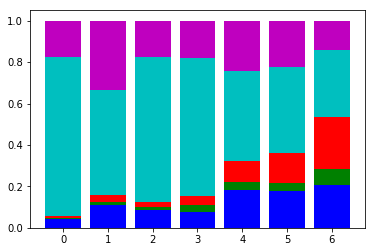

<Figure size 1440x720 with 0 Axes>

In [99]:
import numpy as np
import matplotlib.pyplot as plt

valeurs = period_relative_model
colours = ['b','g','r','c','m','y','k'] #to make sure colours remain the same throughout all slices
    

for key,vals in valeurs.items():
    print(key,vals)
    print(type(key),type(vals))
    
    for i in range(0,len(vals)):        
        if i == 0:
            previous = 0
            plt.bar(x=key, height=vals[i],bottom=previous,color=colours[i])
            
        else:         
            previous = vals[i-1] + previous
            plt.bar(x=key, height=vals[i],bottom=previous,color=colours[i])
            
plt.xticks(range(len(valeurs)), valeurs.keys())

plt.figure(figsize=(20,10))
plt.savefig(dir_out+"/mus_model.png")
plt.show()
